[Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview)

toxicity的类型有：

- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

一个评论可以属于0到多个标签。

![image-20201226152702981](images/image-20201226152702981.png)


## 获取数据

首先引入需要的包。

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf

from collections import Counter
from nltk.corpus import stopwords
from scipy import stats
from sklearn.feature_extraction import text
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


base_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/code'
sys.path.append(base_path)

import util
from text_classification import lr_schedule
from text_classification import plot_distribution, plot_length_distribution, plot_frequency_distribution
from text_classification import Params, TextClassificationHelper
from text_classification import SimpleTextDatasets, SequenceTextDatasets, RawTextDatasets,TransferTextDatasets

# 代码自动重新加载
%load_ext autoreload
%autoreload 2

In [2]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

设置GPU最大内存。

In [3]:
util.set_gpu_memory_growth()
model_results={}

初始化参数。

In [59]:
def lr_schedule(epoch, lr):
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        # ??lr?new_lr???????0.1??new_lr?????lr
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

nltk.download('stopwords')

dataset_name = 'tox_{}_c6'.format(util.get_notebook_name().split('_')[1])
dataset_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/{}'.format(dataset_name)
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'

params = {
    'dataset_name': dataset_name,
    'program_name': util.get_notebook_name(),
    'dataset_path': dataset_path,
    'sample_perecent': 1,    
    'text_column': '',    
    'classes': ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
    'validation_percent': 0.0,    
    'stop_words':stopwords.words('english'),
    'use_stop_words': True,    
    'batch_size': 32,    
    'max_features': 30000,
    'sequence_length': 100,    
    'epochs': 3,    
    'learning_rate':0.001,
    'clip_value':1.0,
    'dropout':0.1,
    'metrics':[metrics.BinaryAccuracy(), metrics.AUC(name='auc', multi_label=True)], 
    'loss': losses.BinaryCrossentropy(from_logits=False),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_binary_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_binary_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.6, 'layer_count':1, 'units':256, 'epochs':5},
        'rnn':{'dropout':0.3, 'embedding_dim':200, 'units':200, 'epochs':3},
        'embedding':{'dropout':0.4, 'embedding_dim':200, 'epochs':3},
        'sepcnn':{'dropout':0.4, 'epochs': 3, 'batch_size':128},
        'pooled_gru':{'dropout':0.3, 'embedding_dim':300, 'units':160, 'epochs':6, 'learning_rate':0.001}     
    },
    'embedding_paths':{
        'fasttext_crawl_300d_2M':os.path.join(word_vectors_path, 'fasttext-crawl-300d-2M.vec'),
        'glove_twitter_27B_200d':os.path.join(word_vectors_path, 'glove.twitter.27B.200d.txt')
    }
}

params = Params(params)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 加载数据

开始加载数据。数据下载自https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data 。其中有三个文件，分别是：

- train.csv：  训练数据，包含文本和标签
- test.csv： 测试数据，只包含文本
- test_labels.csv：测试数据标签，只包含文本标签

In [5]:
df_train = pd.read_csv('./data/jigsaw-toxic-comment-classification-challenge/train.csv')
df_test_data = pd.read_csv('./data/jigsaw-toxic-comment-classification-challenge/test.csv')
df_test_labels = pd.read_csv('./data/jigsaw-toxic-comment-classification-challenge/test_labels.csv')

print('-'*100) 
print('df_train=', len(df_train))
print('-'*100) 
print('df_test_data', len(df_test_data))
print('-'*100) 
print('df_test_labels', len(df_test_labels))

----------------------------------------------------------------------------------------------------
df_train= 159571
----------------------------------------------------------------------------------------------------
df_test_data 153164
----------------------------------------------------------------------------------------------------
df_test_labels 153164


In [6]:
print('-'*100) 
print(df_train.info())
print('-'*100) 
print(df_test_data.info())
print('-'*100) 
print(df_test_labels.info())

----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
None
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----

In [7]:
display(df_train.head())
display(df_test_data.head())
display(df_test_labels.head())

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [8]:
df_test = df_test_data.join(df_test_labels.set_index('id'), on='id')
print('df_test=', len(df_test))
print('-'*100) 
display(df_test.sample(5))

df_test= 153164
----------------------------------------------------------------------------------------------------


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
48769,50f2f081e55a5331,""" \n ::The link in the reference takes you to ...",-1,-1,-1,-1,-1,-1
147212,f61578cf00908839,":OK, Dr. Blofeld, first off I'd like to thank ...",-1,-1,-1,-1,-1,-1
141768,ed01689cbce9b4f2,""" \n\n == Grammar/style == \n\n """"A member of ...",-1,-1,-1,-1,-1,-1
79399,8482b3ab702edaac,""":Suppose Ivan Ivanovitch was born 6 January 1...",-1,-1,-1,-1,-1,-1
61594,6688ee5cfa1a0efa,"""Siegel Center/Rowdy Rams \n\n The """"You Suck""...",0,0,0,0,0,0


In [9]:
df_test = df_test.loc[df_test[params.classes].max(axis=1)>=0]

print('df_test=', len(df_test))
print('-'*100) 
display(df_test.sample(5))

df_test= 63978
----------------------------------------------------------------------------------------------------


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
124646,d03b356fab0fd514,:Socrates2008 has again reverted the removal o...,0,0,0,0,0,0
26927,2ccd6e9ad6f50094,":In answer to your apparent question, yes, I a...",1,0,0,0,1,0
121054,ca1f59013bc0f1f7,""" \n\n ==Reply== \n I dont know how to work it...",0,0,0,0,0,0
58276,60ef3fcef7e80d5e,"|decline=no reason to unblock, you are clearly...",0,0,0,0,0,0
66844,6f4d9e109eebc615,== Amateur vs Pro Wrestling == \n\n The articl...,0,0,0,0,0,0


看了一些kaggle上别人的模型，看上去他们那时候的数据集时直接把训练数据拆分的。

In [10]:
df_train, df_test = train_test_split(df_train, test_size=0.05, random_state=233)



In [11]:
print('-'*100) 
print('df_train=', len(df_train))
print('-'*100) 
print('df_test', len(df_test))
display(df_train.sample(5))
display(df_test.sample(5))

----------------------------------------------------------------------------------------------------
df_train= 151592
----------------------------------------------------------------------------------------------------
df_test 7979


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
138982,e7c407179eebc323,"""\n\n ]]Ozymandias\nPercy Bysshe Shelley, 1792...",0,0,0,0,0,0
14454,262d4d61e18ea100,"""\nI have just used the wayback machine well s...",0,0,0,0,0,0
82556,dcd904f58dfdd13f,Hulk (comics)==\nWe need your help. The persis...,0,0,0,0,0,0
54493,91a6cb38f262605c,"""\nOops, my bad. Here's the explanation. Whe...",0,0,0,0,0,0
37394,63d7e8ea778ce621,Done. I infer he retired due to injury because...,0,0,0,0,0,0


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
19777,343fec7d793ee634,"""\nActually my position is that Dummett being ...",0,0,0,0,0,0
85839,e59dfcd553a1604f,Why you delete my comment on Catholic Jihad? \...,0,0,0,0,0,0
122914,918be13e3cf5cf4d,what my best friend says,0,0,0,0,0,0
85918,e5cced2b0b03dce8,"""\n\nWikipedia Regrets The Errors\n\nFrom June...",0,0,0,0,0,0
5387,0e5c79a45b238ed0,Not only is there a wholly reliable source ind...,0,0,0,0,0,0


### 查看数据

下面看一看实际的数据是啥样的。

In [12]:
for i, row in df_train.sample(5).iterrows():
    print('-'*100) 
    display(row.to_frame().T[params.classes]) 
    print(row["comment_text"]) 

----------------------------------------------------------------------------------------------------


,toxic,severe_toxic,obscene,threat,insult,identity_hate
73424,0,0,0,0,0,0


"For clarity, does ""maths topics ... should be avoided"" constitute a topic ban or advice? - strong advice. I'll unblock you now, if you agree to follow it   

"
----------------------------------------------------------------------------------------------------


,toxic,severe_toxic,obscene,threat,insult,identity_hate
5802,0,0,0,0,0,0


Thank you, I did. The point is not the content of the edit but the arbitrary way you decided to make it.
----------------------------------------------------------------------------------------------------


,toxic,severe_toxic,obscene,threat,insult,identity_hate
127775,0,0,0,0,0,0


"

""Links""
All links from www.shakespeare-online.com are broken!"
----------------------------------------------------------------------------------------------------


,toxic,severe_toxic,obscene,threat,insult,identity_hate
14710,0,0,0,0,0,0


Look, what I have found.  Satish Jarkiholi -
----------------------------------------------------------------------------------------------------


,toxic,severe_toxic,obscene,threat,insult,identity_hate
41,0,0,0,0,0,0


TFD 

I think we just eced. I think we responded to each other without seeing each others responses. I added something in response to yours, but don't know if you saw mine. (T/C//WP:CHICAGO/WP:FOUR)




## 探索数据

接下来，对把数据加载进内存，进行深入一些的探索。

### 基本信息

In [13]:
def get_samples(texts, labels, rate):
    indexs = np.arange(len(texts))
    sample_indexs, _, sample_labels, _ = train_test_split(indexs, labels,                                                          
                                                          test_size=1-rate,
                                                          random_state=12)
    sample_texts = [texts[index] for index in sample_indexs]
    return sample_texts, sample_labels    

def load_toxicity(df, classes=params.classes):
    
    texts = list(df['comment_text'])
    labels = df[classes].to_numpy()

    return texts, labels

train_texts, train_labels = load_toxicity(df_train)
test_texts, test_labels = load_toxicity(df_test)


if params.sample_perecent<1:
    train_texts, train_labels = get_samples(train_texts, train_labels, rate=params.sample_perecent)
    test_texts, test_labels = get_samples(test_texts, test_labels, rate=params.sample_perecent)

print('train_texts.length={}, train_labels.shape={}'.format(len(train_texts), train_labels.shape))
print('test_texts.length={}, test_labels.shape={}'.format(len(test_texts), test_labels.shape))

train_texts.length=151592, train_labels.shape=(151592, 6)
test_texts.length=7979, test_labels.shape=(7979, 6)


In [14]:
test_texts[0]

"Misplaced article\nI noticed that you began to write an article at Portal:Contents.\nI have undone your edit there, because that page is one of the encyclopedia's main index pages. It is not a good place to submit content for the encyclopedia.\nI suggest that you look at Wikipedia:Your first article and perhaps try again using the Article wizard."

### 类别分布

下面统计以下每个类别分别有多少的评论。由于一个评论属于多个类别，所以各个类别汇总后的评论数要大于总评论数。

In [15]:
def get_distribution(labels):
    no_label_count = sum([1 if max(label)==0 else 0 for label in labels])
    labels_count = np.sum(labels, axis=0)
    return np.append(labels_count, no_label_count)

def plot_distribution(train_labels, test_labels, classes):
    def plot_dist(bin_count, title, color='blue', width=0.7):
        bin_percentage = bin_count / np.sum(bin_count)
        rects = plt.bar(np.arange(len(bin_count)), bin_count, width, color=color)
        plt.title(title)
        if classes is None:
            plt.xticks(range(len(bin_count)))
        else:
            plt.xticks(range(len(bin_count)), labels=classes, rotation=45)
        plt.ylim(0, max(bin_count) * 1.1)

        for i, r in enumerate(rects):
            plt.annotate('{:0.1f}%'.format(int(bin_percentage[i] * 100)),
                         xy=(r.get_x() + r.get_width() / 2, r.get_height()),
                         xytext=(0, 3),  # 3 points vertical offset
                         textcoords="offset points",
                         ha='center', va='bottom')
    classes = [class_ for class_ in classes] + ['no_label'] 
    print(classes)
    train_bin_count = get_distribution(train_labels)
    test_bin_count = get_distribution(test_labels)
    if len(classes) <= 10:
        plt.figure(figsize=(min(4 * len(classes), 16), 4))
        plt.subplot(121)
        plot_dist(train_bin_count, 'Train', color='teal')
        plt.subplot(122)
        plot_dist(test_bin_count, 'Test', color='coral')
    else:
        plt.figure(figsize=(20, 12))
        plt.subplot(211)
        plot_dist(train_bin_count, 'Train', color='teal')
        plt.subplot(212)
        plot_dist(test_bin_count, 'Test', color='coral')
    plt.show()

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'no_label']


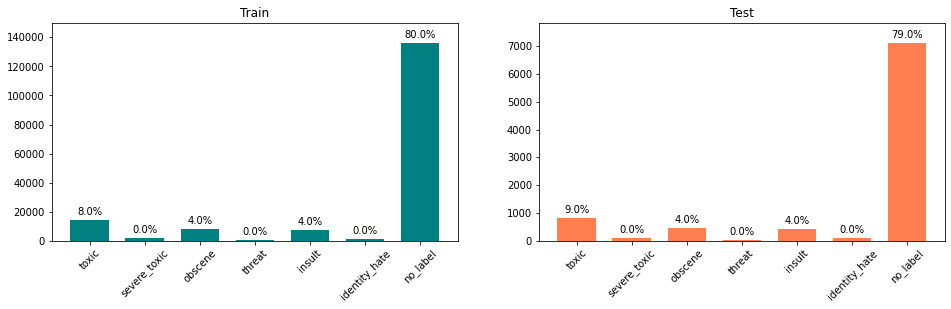

In [16]:
plot_distribution(train_labels, test_labels, params.classes)



### 文本长度分布

分析训练集和测试集的文本长度分布是否相似。

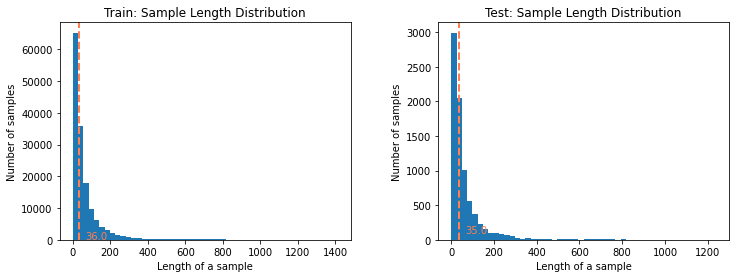

train：mean=67.36 variance=9872.86
test：mean=65.68 variance=9346.42


In [17]:
train_text_lengths = [len(s.split()) for s in train_texts]
test_text_lengths = [len(s.split()) for s in test_texts]
plot_length_distribution(train_text_lengths, test_text_lengths)

print('train：mean={:0.2f} variance={:0.2f}'.format(np.mean(train_text_lengths), 
                                                    np.var(train_text_lengths)))
print('test：mean={:0.2f} variance={:0.2f}'.format(np.mean(test_text_lengths), 
                                                   np.var(test_text_lengths)))



通过图形，中位数，均值和方差的比较，可以认为训练集和测试集文本长度的分布是非常相似的。下面用卡方检验来比较训练集和测试集是否有显著差异。

In [18]:
def process_length(lengths):
    cut_points = [0,99,199,299,399,499,599,699,799,10000]
    labels = ["0-99","100-199","200-299","300-399","400-499","500-599", "600-699","700-799","800+"]
    return pd.cut(lengths, cut_points, labels=labels)

def get_observed(df, column1, column2):
    df_observed = pd.crosstab(
        df[column1],
        df[column2]
    )    
    return df_observed
    
def get_expected(df_observed):
    observed = df_observed.to_numpy()
    reduce_row = observed.sum(axis=0, keepdims=True)/observed.sum()
    reduce_col = observed.sum(axis=1, keepdims=True)

    expected = reduce_col.dot(reduce_row)
    df_expected = pd.DataFrame(expected, index=df_observed.index, columns=df_observed.columns)
    return df_expected
  
def show_sum(df):
    df.columns =  df.columns.tolist()  
    df = df.reset_index()
    s = df.melt(df.columns[0], var_name=' ')
    ct = pd.crosstab(index=s[df.columns[0]], columns=s.iloc[:,1], values=s.value, 
                     aggfunc='sum', margins=True, margins_name='合计',
                     rownames=[''], 
               ) 
    display(ct)
    
length = train_text_lengths + test_text_lengths
dataset = ['train']*len(train_text_lengths) + ['test']*len(test_text_lengths)

df_length = pd.DataFrame({"dataset":dataset, "length":length})
df_length['len'] = process_length(length)
df_observed = get_observed(df_length, 'dataset', 'len')
# display(df_length)

print('-'*25, 'Observed', '-'*25)
show_sum(df_observed)

print('-'*25, 'Expected', '-'*25)
df_expected = get_expected(df_observed)
show_sum(df_expected)

------------------------- Observed -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,6609,872,283,76,42,33,29,19,16,7979
train,124400,17522,5032,1770,897,624,558,481,308,151592
合计,131009,18394,5315,1846,939,657,587,500,324,159571


------------------------- Expected -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,6550.819453,919.751872,265.764989,92.305206,46.952648,32.851853,29.351655,25.00141,16.200914,7979.0
train,124458.180547,17474.248128,5049.235011,1753.694794,892.047352,624.148147,557.648345,474.99859,307.799086,151592.0
合计,131009.000000,18394.000000,5315.000000,1846.000000,939.000000,657.000000,587.000000,500.00000,324.000000,159571.0




然后进行卡方检验。可以看到p_value>0.05，所以接受原假设——数据集来源和文本长度是独立的，也就是说接受训练集和测试集是是相似的分布。

In [19]:
observed = df_observed.to_numpy()
expected = df_expected.to_numpy()

chi_squared_stat = ((observed-expected)**2/expected).sum()
print('chi_squared_stat =', chi_squared_stat)

df = np.prod(np.array(observed.shape) - 1)
critical_value  = stats.chi2.ppf(q=0.95, df=df)  #0.95:置信水平, df:自由度
print('critical_value =', critical_value)        #临界值:拒绝域的边界, 当卡方值大于临界值，则原假设不成立，备择假设成立

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=df)
print('p_value =', p_value)

chi_squared_stat = 9.436054249482249
critical_value = 15.50731305586545
p_value = 0.3068556587694957




### 词频分布

分析训练集和测试集的词频分布是否相似。下面代码中，去除了一些stopwords。

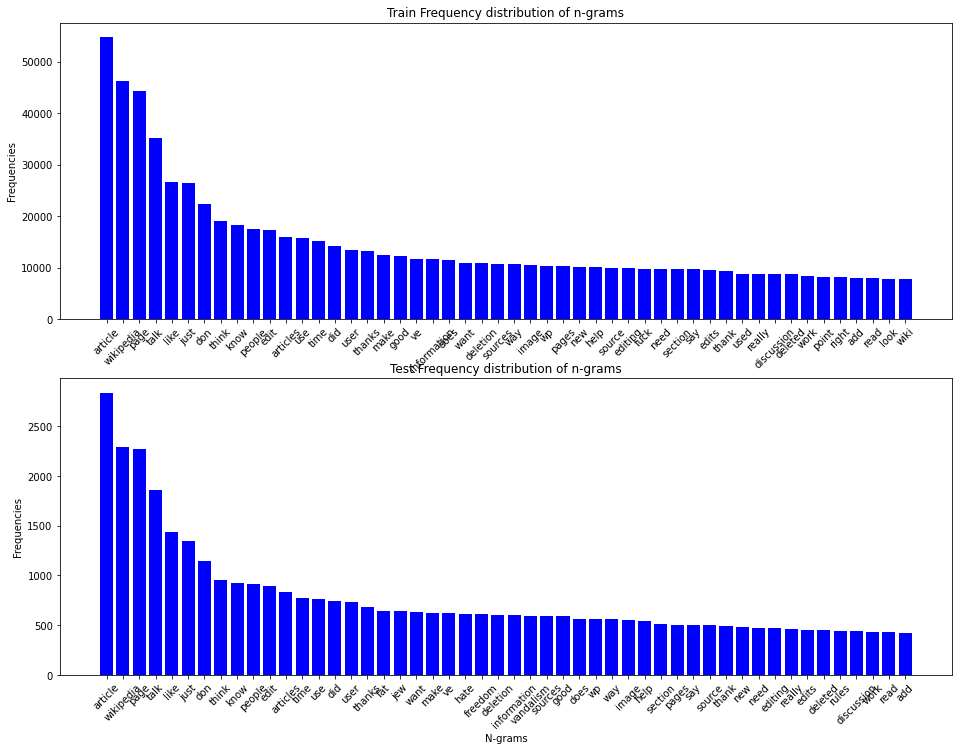

In [20]:
plot_frequency_distribution(train_texts, test_texts)

![image-20201217134151280](images/image-20201217134151280.png)

In [21]:
word_counter = Counter()
for s in train_texts:
    word_counter.update(s.split())
for s in test_texts:
    word_counter.update(s.split())   

print('Number of Vocabulary: {}'.format(len(word_counter)))

for word in list(word_counter):
    if word_counter[word]<25: word_counter.pop(word)
        
print('Number of Vocabulary: {}'.format(len(word_counter)))

Number of Vocabulary: 532299
Number of Vocabulary: 19973




上面可以看到词频大于等于100次的词汇有7706个。

## 准备数据

不同的模型需要准备不同的数据，所以徐要确定一下要构建哪种模型。

### 模型选择

下图是google在两年前提出一个选择流程图。

![image-20201217135347743](images/image-20201217135347743.png)

1. Calculate the number of samples/number of words per sample ratio.
2. If this ratio is less than 1500, tokenize the text as n-grams and use a simple multi-layer perceptron (MLP) model to classify them (left branch in the flowchart below):
   a. Split the samples into word n-grams; convert the n-grams into vectors.
     b. Score the importance of the vectors and then select the top 20K using the scores.
   c. Build an MLP model.
3. If the ratio is greater than 1500, tokenize the text as sequences and use a sepCNN model to classify them (right branch in the flowchart below):
   a. Split the samples into words; select the top 20K words based on their frequency.
   b. Convert the samples into word sequence vectors.
   c. If the original number of samples/number of words per sample ratio is less   than 15K, using a fine-tuned pre-trained embedding with the sepCNN  model will likely provide the best results.
4. Measure the model performance with different hyperparameter values to find
   the best model configuration for the dataset.

In [22]:
length_median = np.median(train_text_lengths)
train_number = len(train_texts)
print ("[the number of samples]/[number of words per sample] = {:0.1f}".format(train_number/length_median))

[the number of samples]/[number of words per sample] = 4210.9


![image-20201217144321430](images/image-20201217144321430.png)

可以看到这个比例大大小于143.7，所以我们从N-gram模型开始，但是同时我们也会为Sequence模型准备数据。数据准备有如下两个过程。

- Tokenization：把文本转化成Token
- Vectorization： 把Token变成Vector

接下来，我们将分别为N-gram模型和Sequence模型准备数据。

### N-gram

在N-gram模型中，Tokenization一般使用unigrams + bigrams的方式把文本转成Token，而Vectorization过程，一般先统计Token的BOW（Bag of Words，词袋模型），然后采用tf-idf在对词频进行平衡。

In [23]:
params.max_features

30000

In [24]:
ngram_vectorizer = util.NgramVectorizer()
if params.use_stop_words:
    ngram_vectorizer.fit(train_texts, train_labels,
                         top_k=params.max_features, ngram_range=(1, 2),
                         stop_words=params.stop_words)
else:
    ngram_vectorizer.fit(train_texts, train_labels,
                         top_k=params.max_features, ngram_range=(1, 2),
                         stop_words=None)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:1808: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


In [25]:
print(len(ngram_vectorizer.vectorizer.vocabulary_))

562985




可以看到上面数据是以稀疏矩阵的形式存在的。下面创建ngram数据集。

In [26]:
ngram_datasets = SimpleTextDatasets(params, train_texts, train_labels, test_texts, test_labels, ngram_vectorizer)
                               
train_ngram = ngram_datasets.train_data
test_ngram = ngram_datasets.test_data
    
print(train_ngram.shape, type(train_ngram), train_ngram.dtype)
print(test_ngram.shape, type(test_ngram), test_ngram.dtype)
print(train_ngram[0, 0:100])                               

save object to ./models/tox_16k_c6/toxicity_16k_0414/SimpleTextDatasets.vectorizer
create train, validation and test dataset
(151592, 30000) <class 'scipy.sparse.csr.csr_matrix'> float32
(7979, 30000) <class 'scipy.sparse.csr.csr_matrix'> float32



In [27]:
test_labels.shape

(7979, 6)

### Sequence

![Embedding Layer](images/EmbeddingLayer.png)

如上图所示，和N-gram模型不同，Sequence模型并不统计词频，它保持了文本的原始顺序，把其中的每个词汇单独变成一个One-hot向量，然后采用Word embedding的方式生成更加有意义的词向量，最后输出到RNN，CNN等模型中。下面将采用两种方式生成Sequence向量。

- Tokenizer
- TextVectorization

#### Tokenizer

In [28]:
print(params.sequence_length)
print(params.max_features)

100
30000


In [29]:
sequence_vectorizer = util.SequenceVectorizer()
sequence_vectorizer.fit(train_texts+test_texts, num_words=params.max_features, 
                        max_sequence_length =params.sequence_length)



创建sequence数据集。

In [30]:
print(len(sequence_vectorizer.tokenizer.word_index))

219321


In [31]:
sequence_datasets = SequenceTextDatasets(params, train_texts, train_labels, test_texts, test_labels, sequence_vectorizer)

train_seq = sequence_datasets.train_data
test_seq = sequence_datasets.test_data

print(train_seq.shape, type(train_seq), train_seq.dtype)
print(test_seq.shape, type(test_seq), test_seq.dtype)
print(test_seq[1])

save object to ./models/tox_16k_c6/toxicity_16k_0414/SequenceTextDatasets.vectorizer
create train, validation and test dataset
(151592, 100) <class 'numpy.ndarray'> int32
(7979, 100) <class 'numpy.ndarray'> int32
[   5  137  195   11  981    6   34  228 2501 3071   20    5  891  636
    5   30 1665   54  567   26   96  885    7  353 2540   11   73  491
  135  254   21   63 1707    1   13   56  118   30    5  352 2091    1
    5  100 5713   28   54  352  330   45   76  150 2135   26   34 2906
    1   72    3  152    5  332   36  726  318    3   93    8   17   59
  131    8   51  935  369    5  584   40   73   44   35  133  152   96
  177   23 1487    5  743   26   21    3   81   93    8  184   43   23
  587   44]


In [32]:
len(sequence_vectorizer.tokenizer.word_index) 

219321

#### Embedding

In [33]:
a = np.random.randint(1,4, (3, 4))
b = np.random.randint(1,4, (2, 4))
print(a)
np.vstack([a, b])

[[3 3 1 2]
 [3 1 2 3]
 [2 1 3 2]]


array([[3, 3, 1, 2],
       [3, 1, 2, 3],
       [2, 1, 3, 2],
       [3, 2, 1, 1],
       [3, 1, 2, 1]])

In [34]:
# def get_embedding_matrix(embeddings_index, vector_size, tokenizer, max_features):
#     word_index = tokenizer.word_index
#     embedding_matrix  = np.zeros((min(max_features, len(word_index)), vector_size))
#     missing_words = {}
#     match_count = 0 
#     for word, i in word_index.items():
#         if i >= max_features: continue
#         vector = embeddings_index.get(word)
#         if vector is not None:
#             embedding_matrix[i] = vector    
#             match_count = match_count + 1
#         else:
#             missing_words[word] = tokenizer.word_counts[word]
#     print('embedding_matrix.shape: {}'.format(embedding_matrix.shape))    
#     print('match cout: {}'.format(match_count))        
#     print('missing word cout: {}'.format(len(missing_words))) 
#     return embedding_matrix

# def load_embedding(embedding_file, max_length=200000, ignore_rows=1):
#     embedding_index = {}
#     with open(embedding_file) as f:
#         i = 0
#         vector_size = 0
#         for line in f:
#             i = i + 1
#             values = line.split()
#             if i<=ignore_rows:                
#                 continue
#             word = values[0]
#             coefs = np.asarray(values[1:], dtype='float32')
#             embedding_index[word] = coefs
#             if i>max_length: break
#     vector_size = len(coefs)
#     print('Loaded %s word vectors. the vector size is %s' % (len(embedding_index), vector_size))   
#     return embedding_index, vector_size    
    
# def load_embedding_matrix(embedding_files, tokenizer, max_features, max_length=200000, ignore_rows=1):
#     if not isinstance(embedding_files, list):
#         embedding_files = [embedding_files]        
    
#     embedding_matrixs = []
#     for embedding_file in embedding_files:
#         print('-'*100)
#         embedding_index, vector_size = load_embedding(embedding_file, max_length)
#         embedding_matrix = get_embedding_matrix(embedding_index, vector_size, 
#                                                               sequence_vectorizer.tokenizer, max_features)
#         embedding_matrixs.append(embedding_matrix)
#     embedding_matrix = np.hstack(embedding_matrixs)
#     return embedding_matrix



In [35]:
embedding_matrix_fasttext_crawl = util.load_embedding_matrix(params.embedding_paths.fasttext_crawl_300d_2M, 
                                                        sequence_vectorizer.tokenizer, 
                                                        max_features = params.max_features,
                                                        max_length=1000000,
                                                        ignore_rows=1
                                                       )

print('-'*100)
embedding_matrix_glove_twitter = util.load_embedding_matrix(params.embedding_paths.glove_twitter_27B_200d,
                                                       sequence_vectorizer.tokenizer, 
                                                       max_features = params.max_features,
                                                       max_length=1000000,
                                                       ignore_rows=0
                                                      )


----------------------------------------------------------------------------------------------------
Loaded 1000000 word vectors. the vector size is 300
embedding_matrix.shape: (30000, 300)
match cout: 27153
missing word cout: 2846
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Loaded 1000001 word vectors. the vector size is 200
embedding_matrix.shape: (30000, 200)
match cout: 26337
missing word cout: 3662


In [36]:
embedding_files = [params.embedding_paths.fasttext_crawl_300d_2M, params.embedding_paths.glove_twitter_27B_200d]
embedding_matrix_fasttext_glove = util.load_embedding_matrix(embedding_files, 
                                                        sequence_vectorizer.tokenizer, 
                                                        max_features = params.max_features,
                                                        max_length=1000000,
                                                        ignore_rows=0
                                                       )

----------------------------------------------------------------------------------------------------
Loaded 1000000 word vectors. the vector size is 300
embedding_matrix.shape: (30000, 300)
match cout: 27153
missing word cout: 2846
----------------------------------------------------------------------------------------------------
Loaded 1000001 word vectors. the vector size is 200
embedding_matrix.shape: (30000, 200)
match cout: 26337
missing word cout: 3662


In [37]:
embedding_matrix_fasttext_glove.shape

(30000, 500)



##  模型

### MLP

In [38]:
class RocAucEvaluation(tf.keras.callbacks.Callback):
    def __init__(self, validation_data=(), interval=1):
        super().__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.4f}".format(epoch+1, score))


# 可以永上面的callback计算AUC，也可以用metrics.AUC(name='auc', multi_label=True)计算，总体差不多，有微小的差别。
# metrics.AUC需要占用较多gpu内存，精度差一点。

In [39]:
def sparse_to_dense(value):
    if isinstance(value, tf.sparse.SparseTensor):
        return tf.sparse.to_dense(value)
    return value

def get_mlp(helper, dropout=None, name='mlp'):
    """Creates an instance of a multi-layer perceptron model"""
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')
    layer_count = helper.get_model_param(name, 'layer_count')
    units = helper.get_model_param(name, 'units')    
    
    input = layers.Input(shape=helper.datasets.input_shape)    
    x = tf.keras.layers.Lambda(sparse_to_dense)(input)
    if dropout>0: x = layers.Dropout(dropout)(x)
        
    for _ in range(layer_count):
        x = layers.Dense(units, activation='relu')(x)
        if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes), activation='sigmoid')(x)  
    
    model = Model(inputs=input, outputs=x, name=name)     
    helper.compile(model)   
    return model

helper = TextClassificationHelper(params, model_results=model_results, datasets=ngram_datasets)
model = get_mlp(helper)
model.summary()

model_params.mlp.dropout=0.6
model_params.mlp.layer_count=1
model_params.mlp.units=256
learning_rate=0.0005
clip_value=1.0
checkpoint_path=./models/tox_16k_c6/toxicity_16k_0414/mlp
Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30000)]           0         
_________________________________________________________________
lambda (Lambda)              (None, 30000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 30000)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               7680256   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense

In [40]:
type(ngram_datasets) 

text_classification.SimpleTextDatasets

use ModelCheckpoint(filepath=./models/tox_16k_c6/toxicity_16k_0414/mlp, monitor=val_binary_accuracy)
use EarlyStopping(monitor=val_binary_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
model_params.mlp.epochs=5
250/250 [==============================] - 1s 5ms/step - loss: 0.6938 - binary_accuracy: 0.4058 - auc: 0.5528
save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/tox_16k_c6/toxicity_16k_0414/mlp.predictor
--------------------------------------------------------------------------------
test loss:0.6938
test binary_accuracy:0.4058


2021-04-15 08:24:39,454: INFO: start training


test auc:0.5913
use_class_weight=None
class_weight=None
Epoch 00001: Still keep learning rate 0.0005 instead of 0.001
Epoch 1/5
4736/4738 [============================>.] - ETA: 0s - loss: 0.1121 - binary_accuracy: 0.9694 - auc: 0.8310WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2021-04-15 08:25:24,714: WARNING: From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2021-04-15 08:25:24,733: WARNING: From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Layer.updates (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/mlp/assets


2021-04-15 08:25:25,442: INFO: Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/mlp/assets



 ROC-AUC - epoch: 1 - score: 0.9481
4738/4738 [==============================] - 45s 10ms/step - loss: 0.1121 - binary_accuracy: 0.9694 - auc: 0.8310 - val_loss: 0.0741 - val_binary_accuracy: 0.9752 - val_auc: 0.9458
Epoch 00002: Still keep learning rate 0.0005 instead of 0.001
Epoch 2/5
4738/4738 [==============================] - ETA: 0s - loss: 0.0850 - binary_accuracy: 0.9737 - auc: 0.8943INFO:tensorflow:Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/mlp/assets


2021-04-15 08:26:13,666: INFO: Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/mlp/assets



 ROC-AUC - epoch: 2 - score: 0.9539
4738/4738 [==============================] - 48s 10ms/step - loss: 0.0850 - binary_accuracy: 0.9737 - auc: 0.8943 - val_loss: 0.0695 - val_binary_accuracy: 0.9766 - val_auc: 0.9436
Epoch 00003: Still keep learning rate 0.0005 instead of 0.001
Epoch 3/5
4735/4738 [============================>.] - ETA: 0s - loss: 0.0814 - binary_accuracy: 0.9747 - auc: 0.8986INFO:tensorflow:Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/mlp/assets


2021-04-15 08:27:04,383: INFO: Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/mlp/assets



 ROC-AUC - epoch: 3 - score: 0.9568
4738/4738 [==============================] - 51s 11ms/step - loss: 0.0814 - binary_accuracy: 0.9747 - auc: 0.8986 - val_loss: 0.0663 - val_binary_accuracy: 0.9775 - val_auc: 0.9491
Epoch 00004: Still keep learning rate 0.0005 instead of 0.001
Epoch 4/5
4734/4738 [============================>.] - ETA: 0s - loss: 0.0789 - binary_accuracy: 0.9758 - auc: 0.9032INFO:tensorflow:Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/mlp/assets


2021-04-15 08:27:54,620: INFO: Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/mlp/assets



 ROC-AUC - epoch: 4 - score: 0.9578
4738/4738 [==============================] - 50s 11ms/step - loss: 0.0789 - binary_accuracy: 0.9758 - auc: 0.9032 - val_loss: 0.0648 - val_binary_accuracy: 0.9782 - val_auc: 0.9451
Epoch 00005: Still keep learning rate 0.0005 instead of 0.001
Epoch 5/5
4738/4738 [==============================] - ETA: 0s - loss: 0.0780 - binary_accuracy: 0.9761 - auc: 0.9066
 ROC-AUC - epoch: 5 - score: 0.9585
4738/4738 [==============================] - 41s 9ms/step - loss: 0.0780 - binary_accuracy: 0.9761 - auc: 0.9066 - val_loss: 0.0645 - val_binary_accuracy: 0.9778 - val_auc: 0.9466


2021-04-15 08:28:37,336: INFO: finish training [elapsed time: 237.88 seconds]


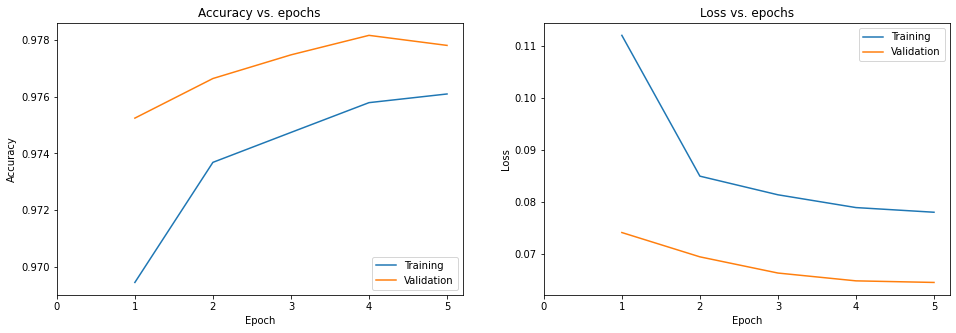

In [41]:
callbacks = helper.get_callbacks(model, verbose=True)
roc_aoc =  RocAucEvaluation(validation_data=(ngram_datasets.test_data, ngram_datasets.test_labels), interval=1)
callbacks.append(roc_aoc)

history = helper.train(model, callbacks=callbacks)

In [42]:
helper.model_summary(model, history=history)

---------------------------------------- evaluate ----------------------------------------
load best checkpoint from ./models/tox_16k_c6/toxicity_16k_0414/mlp
learning_rate=0.0005
clip_value=1.0
checkpoint_path=./models/tox_16k_c6/toxicity_16k_0414/mlp
250/250 [==============================] - 1s 5ms/step - loss: 0.0648 - binary_accuracy: 0.9782 - auc: 0.9451
save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/tox_16k_c6/toxicity_16k_0414/mlp.predictor
--------------------------------------------------------------------------------
test loss:0.0648
test binary_accuracy:0.9782
test auc:0.9578
-------------------------------------------------- all models --------------------------------------------------


,weight_number,train_time,train_loss,test_loss,train_binary_accuracy,test_binary_accuracy,train_auc,test_auc
mlp,7681798,237.0,0.0544,0.0648,0.9816,0.9782,0.9696,0.9578


save json to ./models/tox_16k_c6/toxicity_16k_0414/model_results.json


### Embedding

In [43]:
def get_embedding(helper,
                  dropout=None,
                  name='embedding',
                  embedding_matrix=None,
                  is_embedding_trainable=False,
                  mask_zero=False
                ):

    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')
    
    if embedding_matrix is None:
        embedding_dim = helper.get_model_param(name, 'embedding_dim')   
        num_features = helper.params.max_features+1  
    else:
        num_features, embedding_dim = embedding_matrix.shape
            
    input_shape = helper.datasets.input_shape
    num_classes = len(helper.params.classes)
    
    model = models.Sequential(name=name)
    if embedding_matrix is None:
        model.add(layers.Embedding(input_dim=num_features, 
                                   output_dim=embedding_dim,                               
                                   input_length=input_shape[0],
                                   mask_zero=mask_zero
                                  ))
    else:
        num_features, embedding_dim = embedding_matrix.shape
        model.add(layers.Embedding(input_dim=num_features, 
                                   output_dim=embedding_dim,     
                                   weights=[embedding_matrix],                                   
                                   input_length=input_shape[0],
                                   trainable=is_embedding_trainable,
                                   mask_zero=mask_zero                             
                                  ))     
    model.add(layers.GlobalAveragePooling1D())
    if dropout>0: model.add(layers.Dropout(rate=dropout))
    model.add(layers.Dense(num_classes, activation='sigmoid'))
    helper.compile(model)  
    return model



helper = TextClassificationHelper(params, model_results=model_results, datasets=sequence_datasets)
model = get_embedding(helper)
model.summary()

model_params.embedding.dropout=0.4
model_params.embedding.embedding_dim=200
learning_rate=0.0005
clip_value=1.0
checkpoint_path=./models/tox_16k_c6/toxicity_16k_0414/embedding
Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 200)          6000200   
_________________________________________________________________
global_average_pooling1d (Gl (None, 200)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1206      
Total params: 6,001,406
Trainable params: 6,001,406
Non-trainable params: 0
_________________________________________________________________


model_params.embedding.epochs=3
use ModelCheckpoint(filepath=./models/tox_16k_c6/toxicity_16k_0414/embedding, monitor=val_binary_accuracy)
use EarlyStopping(monitor=val_binary_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
250/250 [==============================] - 2s 6ms/step - loss: 0.6925 - binary_accuracy: 0.3725 - auc: 0.5207
save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/tox_16k_c6/toxicity_16k_0414/embedding.predictor
--------------------------------------------------------------------------------
test loss:0.6925
test binary_accuracy:0.3725


2021-04-15 08:29:46,879: INFO: start training


test auc:0.5452
use_class_weight=None
class_weight=None
Epoch 00001: Still keep learning rate 0.0005 instead of 0.001
Epoch 1/3
4736/4737 [============================>.] - ETA: 0s - loss: 0.1293 - binary_accuracy: 0.9636 - auc: 0.8189INFO:tensorflow:Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/embedding/assets


2021-04-15 08:33:20,260: INFO: Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/embedding/assets


4737/4737 [==============================] - 211s 45ms/step - loss: 0.1293 - binary_accuracy: 0.9636 - auc: 0.8189 - val_loss: 0.1040 - val_binary_accuracy: 0.9648 - val_auc: 0.9240
Epoch 00002: Still keep learning rate 0.0005 instead of 0.001
Epoch 2/3
4737/4737 [==============================] - ETA: 0s - loss: 0.0866 - binary_accuracy: 0.9701 - auc: 0.9262INFO:tensorflow:Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/embedding/assets


2021-04-15 08:37:00,038: INFO: Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/embedding/assets


4737/4737 [==============================] - 219s 46ms/step - loss: 0.0866 - binary_accuracy: 0.9701 - auc: 0.9262 - val_loss: 0.0924 - val_binary_accuracy: 0.9700 - val_auc: 0.9315
Epoch 00003: Still keep learning rate 0.0005 instead of 0.001
Epoch 3/3
4737/4737 [==============================] - ETA: 0s - loss: 0.0756 - binary_accuracy: 0.9749 - auc: 0.9290INFO:tensorflow:Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/embedding/assets


2021-04-15 08:40:56,486: INFO: Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/embedding/assets


4737/4737 [==============================] - 236s 50ms/step - loss: 0.0756 - binary_accuracy: 0.9749 - auc: 0.9290 - val_loss: 0.0869 - val_binary_accuracy: 0.9738 - val_auc: 0.9363


2021-04-15 08:40:57,023: INFO: finish training [elapsed time: 670.14 seconds]


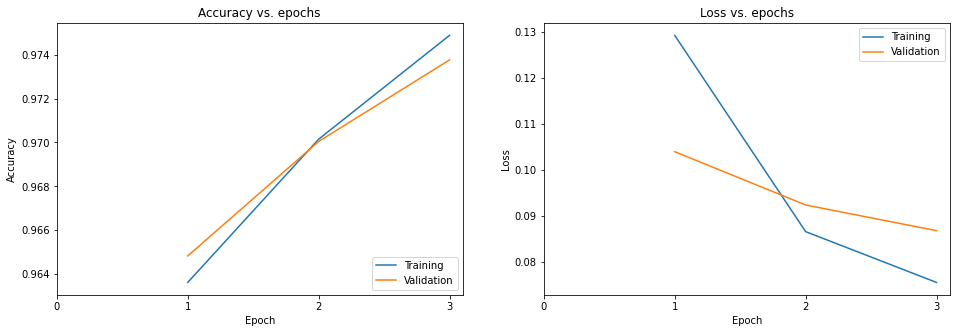

In [44]:
history = helper.train(model)

In [45]:
helper.model_summary(model, history=history)

---------------------------------------- evaluate ----------------------------------------
load best checkpoint from ./models/tox_16k_c6/toxicity_16k_0414/embedding
learning_rate=0.0005
clip_value=1.0
checkpoint_path=./models/tox_16k_c6/toxicity_16k_0414/embedding
250/250 [==============================] - 3s 11ms/step - loss: 0.0869 - binary_accuracy: 0.9738 - auc: 0.9363
save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/tox_16k_c6/toxicity_16k_0414/embedding.predictor
--------------------------------------------------------------------------------
test loss:0.0869
test binary_accuracy:0.9738
test auc:0.9436
-------------------------------------------------- all models --------------------------------------------------


,weight_number,train_time,train_loss,test_loss,train_binary_accuracy,test_binary_accuracy,train_auc,test_auc
mlp,7681798,237.0,0.0544,0.0648,0.9816,0.9782,0.9696,0.9578
embedding,6001406,670.0,0.0702,0.0869,0.9769,0.9738,0.9557,0.9436


save json to ./models/tox_16k_c6/toxicity_16k_0414/model_results.json


model_params.embedding_pretrain.dropout=0.4
learning_rate=0.0005
clip_value=1.0
checkpoint_path=./models/tox_16k_c6/toxicity_16k_0414/embedding_pretrain
Model: "embedding_pretrain"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          9000000   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 300)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 1806      
Total params: 9,001,806
Trainable params: 1,806
Non-trainable params: 9,000,000
_________________________________________________________________
model_params.embedding_pretrain.epochs=3
use ModelCheckpoint(filepath=./models/

2021-04-15 08:42:31,965: INFO: start training


test auc:0.4753
use_class_weight=None
class_weight=None
Epoch 00001: Still keep learning rate 0.0005 instead of 0.001
Epoch 1/3
4731/4737 [============================>.] - ETA: 0s - loss: 0.2283 - binary_accuracy: 0.9609 - auc: 0.6119INFO:tensorflow:Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/embedding_pretrain/assets


2021-04-15 08:43:03,515: INFO: Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/embedding_pretrain/assets


4737/4737 [==============================] - 30s 6ms/step - loss: 0.2282 - binary_accuracy: 0.9609 - auc: 0.6121 - val_loss: 0.1490 - val_binary_accuracy: 0.9613 - val_auc: 0.6879
Epoch 00002: Still keep learning rate 0.0005 instead of 0.001
Epoch 2/3
4732/4737 [============================>.] - ETA: 0s - loss: 0.1243 - binary_accuracy: 0.9644 - auc: 0.7400INFO:tensorflow:Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/embedding_pretrain/assets


2021-04-15 08:43:41,274: INFO: Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/embedding_pretrain/assets


4737/4737 [==============================] - 38s 8ms/step - loss: 0.1242 - binary_accuracy: 0.9644 - auc: 0.7401 - val_loss: 0.1207 - val_binary_accuracy: 0.9625 - val_auc: 0.7737
Epoch 00003: Still keep learning rate 0.0005 instead of 0.001
Epoch 3/3
4734/4737 [============================>.] - ETA: 0s - loss: 0.1074 - binary_accuracy: 0.9657 - auc: 0.8039INFO:tensorflow:Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/embedding_pretrain/assets


2021-04-15 08:44:32,680: INFO: Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/embedding_pretrain/assets


4737/4737 [==============================] - 51s 11ms/step - loss: 0.1074 - binary_accuracy: 0.9657 - auc: 0.8040 - val_loss: 0.1107 - val_binary_accuracy: 0.9639 - val_auc: 0.8225


2021-04-15 08:44:33,201: INFO: finish training [elapsed time: 121.24 seconds]


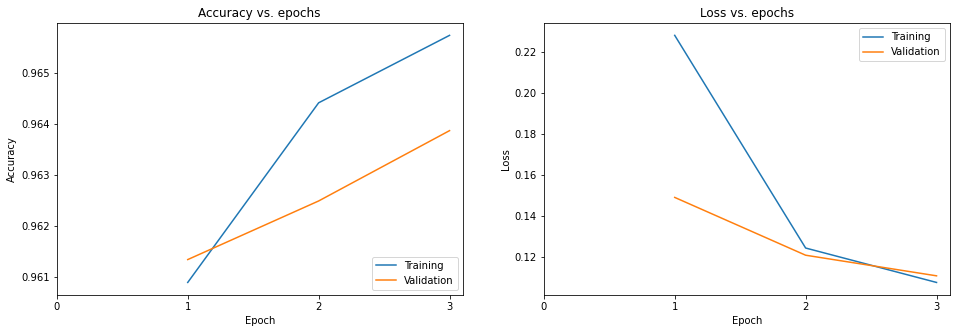

---------------------------------------- evaluate ----------------------------------------
load best checkpoint from ./models/tox_16k_c6/toxicity_16k_0414/embedding_pretrain
learning_rate=0.0005
clip_value=1.0
checkpoint_path=./models/tox_16k_c6/toxicity_16k_0414/embedding_pretrain
250/250 [==============================] - 1s 4ms/step - loss: 0.1107 - binary_accuracy: 0.9639 - auc: 0.8225
save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/tox_16k_c6/toxicity_16k_0414/embedding_pretrain.predictor
--------------------------------------------------------------------------------
test loss:0.1107
test binary_accuracy:0.9639
test auc:0.8290
-------------------------------------------------- all models --------------------------------------------------


,weight_number,train_time,train_loss,test_loss,train_binary_accuracy,test_binary_accuracy,train_auc,test_auc
mlp,7681798,237.0,0.0544,0.0648,0.9816,0.9782,0.9696,0.9578
embedding,6001406,670.0,0.0702,0.0869,0.9769,0.9738,0.9557,0.9436
embedding_pretrain,9001806,121.0,0.1021,0.1107,0.9662,0.9639,0.8414,0.8290


save json to ./models/tox_16k_c6/toxicity_16k_0414/model_results.json


In [46]:
model = get_embedding(helper, name='embedding_pretrain', 
                       embedding_matrix=embedding_matrix_fasttext_crawl, is_embedding_trainable=False)
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

### sepCNN

In [47]:
def get_sepcnn(helper,
                 blocks=1,
                 filters=64,
                 kernel_size=3,
                 embedding_dim=200,
                 dropout=None,
                 pool_size=3,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None, 
                 name='sepcnn'
                ):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')
        
    input_shape = helper.datasets.input_shape
    num_classes = len(helper.params.classes)
    num_features = helper.params.max_features+1  
    
    model = models.Sequential(name=name)

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(layers.Embedding(input_dim=num_features,
                                   output_dim=embedding_dim,
                                   input_length=input_shape[0],
                                   weights=[embedding_matrix],
                                   trainable=is_embedding_trainable))
    else:
        model.add(layers.Embedding(input_dim=num_features,
                                   output_dim=embedding_dim,
                                   input_length=input_shape[0]))

    for i in range(blocks):
        model.add(layers.Dropout(rate=dropout))
        if i==blocks-1: filters=filters*2
        model.add(layers.SeparableConv1D(filters=filters,
                                         kernel_size=kernel_size,
                                         activation='relu',
                                         bias_initializer='random_uniform',
                                         depthwise_initializer='random_uniform',
                                         padding='same'))
        model.add(layers.SeparableConv1D(filters=filters,     
                                         kernel_size=kernel_size,
                                         activation='relu',
                                         bias_initializer='random_uniform',
                                         depthwise_initializer='random_uniform',
                                         padding='same'))
        model.add(layers.MaxPooling1D(pool_size=pool_size))

    model.add(layers.GlobalAveragePooling1D())
    if dropout>0: model.add(layers.Dropout(rate=dropout))
    model.add(layers.Dense(num_classes, activation='sigmoid'))
    helper.compile(model)  
    return model


helper = TextClassificationHelper(params, model_results=model_results, datasets=sequence_datasets)
model = get_sepcnn(helper, blocks=1)
# when bolcks=2, the model can't converg
model.summary()

model_params.sepcnn.dropout=0.4
learning_rate=0.0005
clip_value=1.0
checkpoint_path=./models/tox_16k_c6/toxicity_16k_0414/sepcnn
Model: "sepcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 200)          6000200   
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 200)          0         
_________________________________________________________________
separable_conv1d (SeparableC (None, 100, 128)          26328     
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 100, 128)          16896     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 33, 128)           0         
_________________________________________________________________
global_average_pooling1d_2 ( (None, 128)               0       

In [48]:
# history = helper.train(model, batch_size=32)

In [49]:
# helper.model_summary(model, history=history)

### LSTM

In [50]:
def get_lstm(helper, name='rnn_lstm', 
             dropout=None, 
             is_embedding_trainable=False,
             embedding_matrix=None,
             mask_zero=True,
             use_bidirectional = False,
             use_stacked = False
            ):
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')   

    units = helper.get_model_param(name, 'units')
    max_features = helper.get_model_param(name, 'max_features')
    embedding_dim = helper.get_model_param(name, 'embedding_dim') 
    
    input = layers.Input(shape=helper.datasets.input_shape)
    if embedding_matrix is None:
        x = layers.Embedding(input_dim=max_features+1, output_dim=embedding_dim)(input)
    else:
        num_features, embedding_dim = embedding_matrix.shape
        x = layers.Embedding(input_dim=num_features,
                             output_dim=embedding_dim,
                             weights=[embedding_matrix],
                             trainable=is_embedding_trainable,
                             mask_zero=mask_zero
                            )(input)      
    if use_bidirectional and use_stacked:
        x = layers.Bidirectional(layers.LSTM(units=units, return_sequences=True))(x)
        x = layers.LSTM(units=units)(x)
    elif use_bidirectional and not use_stacked:
        x = layers.Bidirectional(layers.LSTM(units=units, return_sequences=True))(x)
    else:
        x = layers.LSTM(units=units)(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes), activation='sigmoid')(x)  
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)      
    return model 

helper = TextClassificationHelper(params, model_results=model_results, datasets=sequence_datasets)
model = get_lstm(helper)
model.summary()


model_params.rnn_lstm.dropout=0.3
model_params.rnn_lstm.units=200
max_features=30000
model_params.rnn_lstm.embedding_dim=200
learning_rate=0.0005
clip_value=1.0
checkpoint_path=./models/tox_16k_c6/toxicity_16k_0414/rnn_lstm
Model: "rnn_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 200)          6000200   
_________________________________________________________________
lstm (LSTM)                  (None, 200)               320800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 1206      
Total params: 6,322,206
Trainabl

In [51]:
# history = helper.train(model)

In [52]:
# model = get_lstm(helper, name='rnn_pretrain',
#                  embedding_matrix=embedding_matrix_cc,
#                  is_embedding_trainable=True,
#                  mask_zero=True)
# model.summary()
# history = helper.train(model)

In [53]:
# model = get_lstm(helper, name='rnn_pretrain',
#                  embedding_matrix=embedding_matrix_cc,
#                  is_embedding_trainable=True,
#                  mask_zero=True)
# model.summary()
# history = helper.train(model)

In [54]:
# helper.model_summary(model, history=history)

### LSTM + Bidirectional + Stacked

In [56]:
def get_lstm_stacked(helper, name='rnn_lstm_stacked', dropout=None):
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')   
    
    units = helper.get_model_param(name, 'units')
    max_features = helper.get_model_param(name, 'max_features')
    embedding_dim = helper.get_model_param(name, 'embedding_dim') 
    
    input = layers.Input(shape=helper.datasets.input_shape)
    x = layers.Embedding(input_dim=max_features, output_dim=embedding_dim, mask_zero=True)(input)
    x = layers.Bidirectional(layers.LSTM(units=units, return_sequences=True))(x)
    x = layers.LSTM(units=units)(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes), activation='sigmoid')(x)  
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)      
    return model 

helper = TextClassificationHelper(params, model_results=model_results, datasets=sequence_datasets)
model = get_lstm_stacked(helper)
model.summary()

model_params.rnn_lstm_stacked.dropout=0.3
model_params.rnn_lstm_stacked.units=200
max_features=30000
model_params.rnn_lstm_stacked.embedding_dim=200
learning_rate=0.0005
clip_value=1.0
checkpoint_path=./models/tox_16k_c6/toxicity_16k_0414/rnn_lstm_stacked
Model: "rnn_lstm_stacked"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 100, 200)          6000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 400)          641600    
_________________________________________________________________
lstm_4 (LSTM)                (None, 200)               480800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0  

In [57]:
# history = helper.train(model)

In [58]:
# helper.model_summary(model, history=history)

### Pooled GRU 
参考 [Pooled GRU + FastText](https://www.kaggle.com/yekenot/pooled-gru-fasttext?select=crawl-300d-2M.vec)

In [60]:
def get_pooled_gru(helper, name='pooled_gru', 
             dropout=None, 
             is_embedding_trainable=False,
             embedding_matrix=None,
             mask_zero=False
            ):
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')   

    units = helper.get_model_param(name, 'units')
    max_features = helper.get_model_param(name, 'max_features')
    embedding_dim = helper.get_model_param(name, 'embedding_dim') 
    
    input = layers.Input(shape=helper.datasets.input_shape)
    if embedding_matrix is None:
        x = layers.Embedding(input_dim=max_features+1, output_dim=embedding_dim)(input)
    else:
        num_features, embedding_dim = embedding_matrix.shape
        x = layers.Embedding(input_dim=num_features,
                             output_dim=embedding_dim,
                             weights=[embedding_matrix],
                             trainable=is_embedding_trainable,
                             mask_zero=mask_zero
                            )(input)      
    x = layers.SpatialDropout1D(dropout)(x)
    
    x = layers.Bidirectional(layers.GRU(units, return_sequences=True))(x)
    x = layers.GRU(units, return_sequences=True)(x)
    
    avg_pool = layers.GlobalAveragePooling1D()(x)
    max_pool = layers.GlobalMaxPooling1D()(x)
    x = layers.concatenate([avg_pool, max_pool])

    
    x = layers.Dense(len(helper.params.classes), activation='sigmoid')(x)  
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)      
    return model 



#### pooled_gru_fasttext

model_params.pooled_gru_fasttext.dropout=0.3
model_params.pooled_gru_fasttext.units=160
max_features=30000
model_params.pooled_gru_fasttext.embedding_dim=300
model_params.pooled_gru_fasttext.learning_rate=0.001
clip_value=1.0
checkpoint_path=./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_fasttext
Model: "pooled_gru_fasttext"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 100, 300)     9000000     input_5[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 100, 300)     0           embedding_6[

2021-04-15 08:56:02,808: INFO: start training


test auc:0.4714
use_class_weight=None
class_weight=None
Epoch 1/6
4737/4737 [==============================] - ETA: 0s - loss: 0.0531 - binary_accuracy: 0.9809 - auc: 0.9590INFO:tensorflow:Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_fasttext/assets


2021-04-15 09:01:25,249: INFO: Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_fasttext/assets


4737/4737 [==============================] - 319s 67ms/step - loss: 0.0531 - binary_accuracy: 0.9809 - auc: 0.9590 - val_loss: 0.0482 - val_binary_accuracy: 0.9821 - val_auc: 0.9757
Epoch 2/6
4737/4737 [==============================] - ETA: 0s - loss: 0.0449 - binary_accuracy: 0.9832 - auc: 0.9747INFO:tensorflow:Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_fasttext/assets


2021-04-15 09:05:49,886: INFO: Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_fasttext/assets


4737/4737 [==============================] - 264s 56ms/step - loss: 0.0449 - binary_accuracy: 0.9832 - auc: 0.9747 - val_loss: 0.0460 - val_binary_accuracy: 0.9831 - val_auc: 0.9785
Epoch 3/6
4737/4737 [==============================] - 270s 57ms/step - loss: 0.0422 - binary_accuracy: 0.9839 - auc: 0.9773 - val_loss: 0.0459 - val_binary_accuracy: 0.9829 - val_auc: 0.9790
Epoch 4/6
4737/4737 [==============================] - ETA: 0s - loss: 0.0404 - binary_accuracy: 0.9845 - auc: 0.9802INFO:tensorflow:Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_fasttext/assets


2021-04-15 09:15:31,142: INFO: Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_fasttext/assets


4737/4737 [==============================] - 310s 66ms/step - loss: 0.0404 - binary_accuracy: 0.9845 - auc: 0.9802 - val_loss: 0.0451 - val_binary_accuracy: 0.9835 - val_auc: 0.9799
Epoch 5/6
4737/4737 [==============================] - ETA: 0s - loss: 0.0380 - binary_accuracy: 0.9853 - auc: 0.9834INFO:tensorflow:Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_fasttext/assets


2021-04-15 09:21:09,196: INFO: Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_fasttext/assets


4737/4737 [==============================] - 338s 71ms/step - loss: 0.0380 - binary_accuracy: 0.9853 - auc: 0.9834 - val_loss: 0.0451 - val_binary_accuracy: 0.9837 - val_auc: 0.9741
Epoch 6/6
4737/4737 [==============================] - 273s 58ms/step - loss: 0.0361 - binary_accuracy: 0.9859 - auc: 0.9855 - val_loss: 0.0459 - val_binary_accuracy: 0.9828 - val_auc: 0.9769


2021-04-15 09:25:43,856: INFO: finish training [elapsed time: 1781.05 seconds]


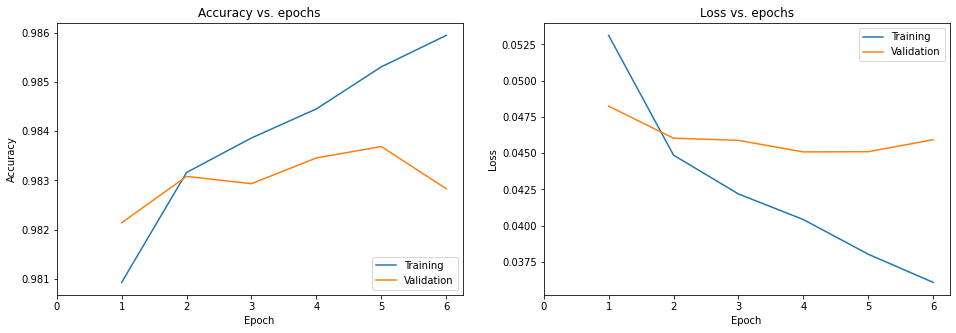

---------------------------------------- evaluate ----------------------------------------
load best checkpoint from ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_fasttext
model_params.pooled_gru_fasttext.learning_rate=0.001
clip_value=1.0
checkpoint_path=./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_fasttext
250/250 [==============================] - 12s 46ms/step - loss: 0.0451 - binary_accuracy: 0.9837 - auc: 0.9741
save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/tox_16k_c6/toxicity_16k_0414/pooled_gru_fasttext.predictor
--------------------------------------------------------------------------------
test loss:0.0451
test binary_accuracy:0.9837
test auc:0.9867
-------------------------------------------------- all models --------------------------------------------------


,weight_number,train_time,train_loss,test_loss,train_binary_accuracy,test_binary_accuracy,train_auc,test_auc
pooled_gru_fasttext,9676806,1781.0,0.0321,0.0451,0.9873,0.9837,0.9935,0.9867
mlp,7681798,237.0,0.0544,0.0648,0.9816,0.9782,0.9696,0.9578
embedding,6001406,670.0,0.0702,0.0869,0.9769,0.9738,0.9557,0.9436
embedding_pretrain,9001806,121.0,0.1021,0.1107,0.9662,0.9639,0.8414,0.8290


save json to ./models/tox_16k_c6/toxicity_16k_0414/model_results.json


In [61]:
helper = TextClassificationHelper(params, model_results=model_results, datasets=sequence_datasets)
model = get_pooled_gru(helper, name='pooled_gru_fasttext', embedding_matrix=embedding_matrix_fasttext_crawl)
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

#### pooled_gru_glove

model_params.pooled_gru_glove.dropout=0.3
model_params.pooled_gru_glove.units=160
max_features=30000
model_params.pooled_gru_glove.embedding_dim=300
model_params.pooled_gru_glove.learning_rate=0.001
clip_value=1.0
checkpoint_path=./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_glove
Model: "pooled_gru_glove"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 100, 200)     6000000     input_6[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 100, 200)     0           embedding_7[0][0]             

2021-04-15 09:35:26,385: INFO: start training


test auc:0.5058
use_class_weight=None
class_weight=None
Epoch 1/6
4737/4737 [==============================] - ETA: 0s - loss: 0.0535 - binary_accuracy: 0.9809 - auc: 0.9555INFO:tensorflow:Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_glove/assets


2021-04-15 09:41:32,527: INFO: Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_glove/assets


4737/4737 [==============================] - 362s 76ms/step - loss: 0.0535 - binary_accuracy: 0.9809 - auc: 0.9555 - val_loss: 0.0486 - val_binary_accuracy: 0.9821 - val_auc: 0.9784
Epoch 2/6
4737/4737 [==============================] - ETA: 0s - loss: 0.0421 - binary_accuracy: 0.9840 - auc: 0.9784INFO:tensorflow:Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_glove/assets


2021-04-15 09:46:53,992: INFO: Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_glove/assets


4737/4737 [==============================] - 321s 68ms/step - loss: 0.0421 - binary_accuracy: 0.9840 - auc: 0.9784 - val_loss: 0.0495 - val_binary_accuracy: 0.9824 - val_auc: 0.9751
Epoch 3/6
4737/4737 [==============================] - ETA: 0s - loss: 0.0378 - binary_accuracy: 0.9852 - auc: 0.9820INFO:tensorflow:Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_glove/assets


2021-04-15 09:52:00,729: INFO: Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_glove/assets


4737/4737 [==============================] - 306s 65ms/step - loss: 0.0378 - binary_accuracy: 0.9852 - auc: 0.9820 - val_loss: 0.0485 - val_binary_accuracy: 0.9829 - val_auc: 0.9716
Epoch 4/6
4737/4737 [==============================] - ETA: 0s - loss: 0.0344 - binary_accuracy: 0.9864 - auc: 0.9868INFO:tensorflow:Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_glove/assets


2021-04-15 09:57:28,839: INFO: Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_glove/assets


4737/4737 [==============================] - 328s 69ms/step - loss: 0.0344 - binary_accuracy: 0.9864 - auc: 0.9868 - val_loss: 0.0482 - val_binary_accuracy: 0.9829 - val_auc: 0.9731
Epoch 5/6
4737/4737 [==============================] - 299s 63ms/step - loss: 0.0305 - binary_accuracy: 0.9879 - auc: 0.9895 - val_loss: 0.0528 - val_binary_accuracy: 0.9812 - val_auc: 0.9668
Epoch 6/6
4737/4737 [==============================] - 308s 65ms/step - loss: 0.0276 - binary_accuracy: 0.9890 - auc: 0.9909 - val_loss: 0.0550 - val_binary_accuracy: 0.9813 - val_auc: 0.9592


2021-04-15 10:07:37,859: INFO: finish training [elapsed time: 1931.47 seconds]


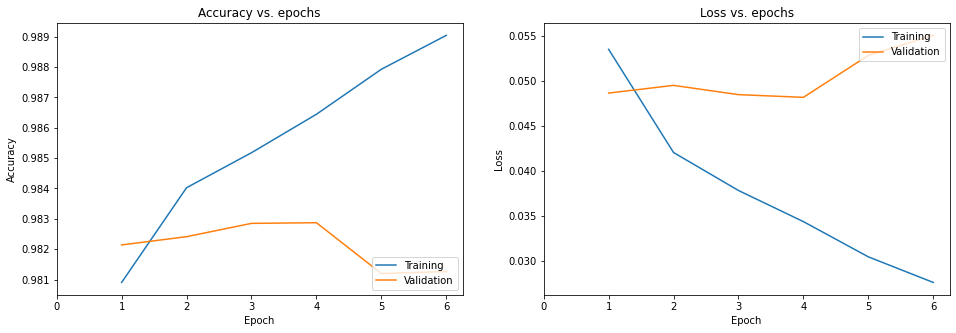

---------------------------------------- evaluate ----------------------------------------
load best checkpoint from ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_glove
model_params.pooled_gru_glove.learning_rate=0.001
clip_value=1.0
checkpoint_path=./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_glove
250/250 [==============================] - 6s 25ms/step - loss: 0.0482 - binary_accuracy: 0.9829 - auc: 0.9731
save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/tox_16k_c6/toxicity_16k_0414/pooled_gru_glove.predictor
--------------------------------------------------------------------------------
test loss:0.0482
test binary_accuracy:0.9829
test auc:0.9840
-------------------------------------------------- all models --------------------------------------------------


,weight_number,train_time,train_loss,test_loss,train_binary_accuracy,test_binary_accuracy,train_auc,test_auc
pooled_gru_fasttext,9676806,1781.0,0.0321,0.0451,0.9873,0.9837,0.9935,0.9867
pooled_gru_glove,6580806,1931.0,0.0275,0.0482,0.9889,0.9829,0.9956,0.9840
mlp,7681798,237.0,0.0544,0.0648,0.9816,0.9782,0.9696,0.9578
embedding,6001406,670.0,0.0702,0.0869,0.9769,0.9738,0.9557,0.9436
embedding_pretrain,9001806,121.0,0.1021,0.1107,0.9662,0.9639,0.8414,0.8290


save json to ./models/tox_16k_c6/toxicity_16k_0414/model_results.json


In [62]:
helper = TextClassificationHelper(params, model_results=model_results, datasets=sequence_datasets)
model = get_pooled_gru(helper, name='pooled_gru_glove',  embedding_matrix=embedding_matrix_glove_twitter, 
                       is_embedding_trainable=True)
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

#### pooled_gru_fasttext_glove

model_params.pooled_gru_fasttext_glove.dropout=0.3
model_params.pooled_gru_fasttext_glove.units=160
max_features=30000
model_params.pooled_gru_fasttext_glove.embedding_dim=300
model_params.pooled_gru_fasttext_glove.learning_rate=0.001
clip_value=1.0
checkpoint_path=./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_fasttext_glove
Model: "pooled_gru_fasttext_glove"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 100, 500)     15000000    input_7[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 10

2021-04-15 10:14:35,126: INFO: start training


test auc:0.4560
use_class_weight=None
class_weight=None
Epoch 1/6
4736/4737 [============================>.] - ETA: 0s - loss: 0.0521 - binary_accuracy: 0.9812 - auc: 0.9588INFO:tensorflow:Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_fasttext_glove/assets


2021-04-15 10:18:58,830: INFO: Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_fasttext_glove/assets


4737/4737 [==============================] - 259s 55ms/step - loss: 0.0521 - binary_accuracy: 0.9812 - auc: 0.9588 - val_loss: 0.0486 - val_binary_accuracy: 0.9823 - val_auc: 0.9818
Epoch 2/6
4737/4737 [==============================] - ETA: 0s - loss: 0.0435 - binary_accuracy: 0.9835 - auc: 0.9756INFO:tensorflow:Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_fasttext_glove/assets


2021-04-15 10:23:01,082: INFO: Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_fasttext_glove/assets


4737/4737 [==============================] - 242s 51ms/step - loss: 0.0435 - binary_accuracy: 0.9835 - auc: 0.9756 - val_loss: 0.0460 - val_binary_accuracy: 0.9829 - val_auc: 0.9780
Epoch 3/6
4737/4737 [==============================] - ETA: 0s - loss: 0.0407 - binary_accuracy: 0.9843 - auc: 0.9797INFO:tensorflow:Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_fasttext_glove/assets


2021-04-15 10:27:42,860: INFO: Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_fasttext_glove/assets


4737/4737 [==============================] - 282s 59ms/step - loss: 0.0407 - binary_accuracy: 0.9843 - auc: 0.9797 - val_loss: 0.0446 - val_binary_accuracy: 0.9832 - val_auc: 0.9778
Epoch 4/6
4737/4737 [==============================] - ETA: 0s - loss: 0.0383 - binary_accuracy: 0.9852 - auc: 0.9821INFO:tensorflow:Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_fasttext_glove/assets


2021-04-15 10:32:21,709: INFO: Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_fasttext_glove/assets


4737/4737 [==============================] - 279s 59ms/step - loss: 0.0383 - binary_accuracy: 0.9852 - auc: 0.9821 - val_loss: 0.0444 - val_binary_accuracy: 0.9836 - val_auc: 0.9787
Epoch 5/6
4737/4737 [==============================] - 231s 49ms/step - loss: 0.0359 - binary_accuracy: 0.9859 - auc: 0.9838 - val_loss: 0.0462 - val_binary_accuracy: 0.9826 - val_auc: 0.9729
Epoch 6/6
4737/4737 [==============================] - 261s 55ms/step - loss: 0.0339 - binary_accuracy: 0.9867 - auc: 0.9864 - val_loss: 0.0491 - val_binary_accuracy: 0.9828 - val_auc: 0.9712


2021-04-15 10:40:34,711: INFO: finish training [elapsed time: 1559.59 seconds]


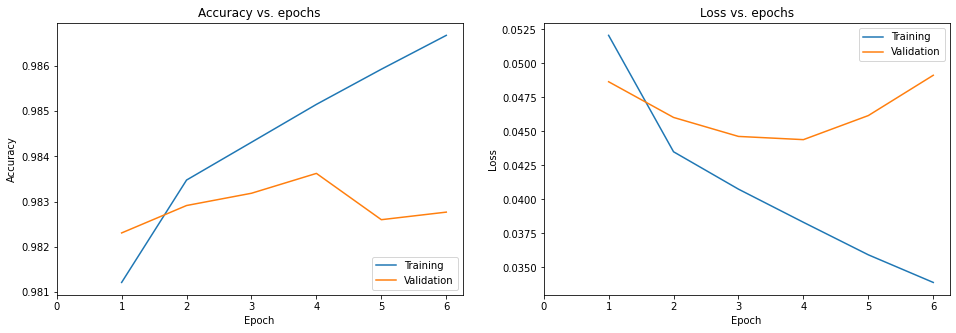

---------------------------------------- evaluate ----------------------------------------
load best checkpoint from ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_fasttext_glove
model_params.pooled_gru_fasttext_glove.learning_rate=0.001
clip_value=1.0
checkpoint_path=./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_fasttext_glove
250/250 [==============================] - 7s 28ms/step - loss: 0.0444 - binary_accuracy: 0.9836 - auc: 0.9787
save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/tox_16k_c6/toxicity_16k_0414/pooled_gru_fasttext_glove.predictor
--------------------------------------------------------------------------------
test loss:0.0444
test binary_accuracy:0.9836
test auc:0.9868
-------------------------------------------------- all models --------------------------------------------------


,weight_number,train_time,train_loss,test_loss,train_binary_accuracy,test_binary_accuracy,train_auc,test_auc
pooled_gru_fasttext,9676806,1781.0,0.0321,0.0451,0.9873,0.9837,0.9935,0.9867
pooled_gru_fasttext_glove,15868806,1559.0,0.0326,0.0444,0.9870,0.9836,0.9932,0.9868
pooled_gru_glove,6580806,1931.0,0.0275,0.0482,0.9889,0.9829,0.9956,0.9840
mlp,7681798,237.0,0.0544,0.0648,0.9816,0.9782,0.9696,0.9578
embedding,6001406,670.0,0.0702,0.0869,0.9769,0.9738,0.9557,0.9436
embedding_pretrain,9001806,121.0,0.1021,0.1107,0.9662,0.9639,0.8414,0.8290


save json to ./models/tox_16k_c6/toxicity_16k_0414/model_results.json


In [63]:
helper = TextClassificationHelper(params, model_results=model_results, datasets=sequence_datasets)
model = get_pooled_gru(helper, name='pooled_gru_fasttext_glove',  embedding_matrix=embedding_matrix_fasttext_glove, 
                       is_embedding_trainable=False)
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

### Pooled GRU Pro

https://www.kaggle.com/larryfreeman/toxic-comments-code-for-alexander-s-9872-model/#data

In [64]:
def get_pooled_gru_pro(helper, name='pooled_gru', 
             dropout=None, 
             is_embedding_trainable=False,
             embedding_matrix=None,
             mask_zero=False
            ):
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')   

    units = helper.get_model_param(name, 'units')
    max_features = helper.get_model_param(name, 'max_features')
    embedding_dim = helper.get_model_param(name, 'embedding_dim') 
    
    input = layers.Input(shape=helper.datasets.input_shape)
    if embedding_matrix is None:
        x = layers.Embedding(input_dim=max_features+1, output_dim=embedding_dim)(input)
    else:
        num_features, embedding_dim = embedding_matrix.shape
        x = layers.Embedding(input_dim=num_features,
                             output_dim=embedding_dim,
                             weights=[embedding_matrix],
                             trainable=is_embedding_trainable,
                             mask_zero=mask_zero
                            )(input)      
    x = layers.SpatialDropout1D(dropout)(x)
    
    x, x_h, x_c = layers.Bidirectional(layers.GRU(units, return_sequences=True, return_state = True))(x)
    x = layers.GRU(units, return_sequences=True)(x)
    avg_pool = layers.GlobalAveragePooling1D()(x)
    max_pool = layers.GlobalMaxPooling1D()(x)
    x = layers.concatenate([avg_pool, x_h, max_pool])

    x = layers.Dense(len(helper.params.classes), activation='sigmoid')(x)  
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)      
    return model 


model_params.pooled_gru_pro_ft_glove.dropout=0.3
model_params.pooled_gru_pro_ft_glove.units=160
max_features=30000
model_params.pooled_gru_pro_ft_glove.embedding_dim=300
model_params.pooled_gru_pro_ft_glove.learning_rate=0.001
clip_value=1.0
checkpoint_path=./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_pro_ft_glove
Model: "pooled_gru_pro_ft_glove"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 100, 500)     15000000    input_8[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, 100, 500)     

2021-04-15 10:48:03,510: INFO: start training


test auc:0.4887
use_class_weight=None
class_weight=None
Epoch 1/6
4737/4737 [==============================] - ETA: 0s - loss: 0.0509 - binary_accuracy: 0.9815 - auc: 0.9641INFO:tensorflow:Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_pro_ft_glove/assets


2021-04-15 10:52:38,863: INFO: Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_pro_ft_glove/assets


4737/4737 [==============================] - 271s 57ms/step - loss: 0.0509 - binary_accuracy: 0.9815 - auc: 0.9641 - val_loss: 0.0498 - val_binary_accuracy: 0.9812 - val_auc: 0.9805
Epoch 2/6
4737/4737 [==============================] - ETA: 0s - loss: 0.0431 - binary_accuracy: 0.9836 - auc: 0.9769INFO:tensorflow:Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_pro_ft_glove/assets


2021-04-15 10:57:48,939: INFO: Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_pro_ft_glove/assets


4737/4737 [==============================] - 310s 65ms/step - loss: 0.0431 - binary_accuracy: 0.9836 - auc: 0.9769 - val_loss: 0.0459 - val_binary_accuracy: 0.9830 - val_auc: 0.9686
Epoch 3/6
4736/4737 [============================>.] - ETA: 0s - loss: 0.0405 - binary_accuracy: 0.9844 - auc: 0.9808INFO:tensorflow:Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_pro_ft_glove/assets


2021-04-15 11:02:33,329: INFO: Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_pro_ft_glove/assets


4737/4737 [==============================] - 284s 60ms/step - loss: 0.0405 - binary_accuracy: 0.9844 - auc: 0.9808 - val_loss: 0.0457 - val_binary_accuracy: 0.9831 - val_auc: 0.9774
Epoch 4/6
4736/4737 [============================>.] - ETA: 0s - loss: 0.0371 - binary_accuracy: 0.9857 - auc: 0.9845INFO:tensorflow:Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_pro_ft_glove/assets


2021-04-15 11:06:37,643: INFO: Assets written to: ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_pro_ft_glove/assets


4737/4737 [==============================] - 244s 52ms/step - loss: 0.0371 - binary_accuracy: 0.9857 - auc: 0.9845 - val_loss: 0.0465 - val_binary_accuracy: 0.9833 - val_auc: 0.9734
Epoch 5/6
4737/4737 [==============================] - 275s 58ms/step - loss: 0.0345 - binary_accuracy: 0.9865 - auc: 0.9865 - val_loss: 0.0474 - val_binary_accuracy: 0.9832 - val_auc: 0.9704
Epoch 6/6
4737/4737 [==============================] - 296s 62ms/step - loss: 0.0318 - binary_accuracy: 0.9876 - auc: 0.9889 - val_loss: 0.0492 - val_binary_accuracy: 0.9823 - val_auc: 0.9714


2021-04-15 11:16:09,815: INFO: finish training [elapsed time: 1686.30 seconds]


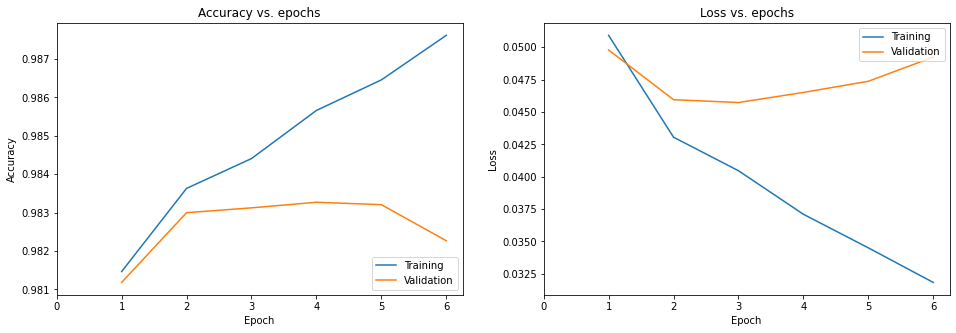

---------------------------------------- evaluate ----------------------------------------
load best checkpoint from ./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_pro_ft_glove
model_params.pooled_gru_pro_ft_glove.learning_rate=0.001
clip_value=1.0
checkpoint_path=./models/tox_16k_c6/toxicity_16k_0414/pooled_gru_pro_ft_glove
250/250 [==============================] - 10s 41ms/step - loss: 0.0465 - binary_accuracy: 0.9833 - auc: 0.9734
save predictor into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/tox_16k_c6/toxicity_16k_0414/pooled_gru_pro_ft_glove.predictor
save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/tox_16k_c6/toxicity_16k_0414/pooled_gru_pro_ft_glove.predictor
--------------------------------------------------------------------------------
test loss:0.0465
test binary_accuracy:0.9833
test auc:0.9861
-------------------------------------------------- all models --------------------------------------------------


,weight_number,train_time,train_loss,test_loss,train_binary_accuracy,test_binary_accuracy,train_auc,test_auc
pooled_gru_fasttext,9676806,1781.0,0.0321,0.0451,0.9873,0.9837,0.9935,0.9867
pooled_gru_fasttext_glove,15868806,1559.0,0.0326,0.0444,0.9870,0.9836,0.9932,0.9868
pooled_gru_pro_ft_glove,15869766,1686.0,0.0320,0.0465,0.9875,0.9833,0.9943,0.9861
pooled_gru_glove,6580806,1931.0,0.0275,0.0482,0.9889,0.9829,0.9956,0.9840
mlp,7681798,237.0,0.0544,0.0648,0.9816,0.9782,0.9696,0.9578
embedding,6001406,670.0,0.0702,0.0869,0.9769,0.9738,0.9557,0.9436
embedding_pretrain,9001806,121.0,0.1021,0.1107,0.9662,0.9639,0.8414,0.8290


save json to ./models/tox_16k_c6/toxicity_16k_0414/model_results.json


In [65]:
helper = TextClassificationHelper(params, model_results=model_results, datasets=sequence_datasets)
model = get_pooled_gru_pro(helper, name='pooled_gru_pro_ft_glove',  embedding_matrix=embedding_matrix_fasttext_glove, 
                       is_embedding_trainable=False)
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)